<a href="https://colab.research.google.com/github/kiseonjeong/computer-vision/blob/2-study-the-super-resolution-algorithm/super%20resolution/cifar10_wdsr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tensorflow_addons

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Load image data
ishape = 128
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

# Reduce the dataset
train_image = train_images[0:10000]
test_image = test_images[0:1000]

x_train = np.array([img for img in train_image])
x_test = np.array([img for img in test_image])

y_train = np.array([cv.resize(img, (ishape, ishape), interpolation=cv.INTER_CUBIC) for img in train_image])
y_test = np.array([cv.resize(img, (ishape, ishape), interpolation=cv.INTER_CUBIC) for img in test_image])


In [5]:
# Get RGB mean values
flatten_train = x_train.reshape(x_train.shape[0], -1, x_train.shape[3])
RGB_MEAN = np.sum(np.sum(flatten_train, axis=0), axis=0) / (flatten_train.shape[0] * flatten_train.shape[1])

In [6]:
def normalize(x, rgb_mean=RGB_MEAN):
    return (x - rgb_mean) / 127.5

def denormalize(x, rgb_mean=RGB_MEAN):
    return x * 127.5 + rgb_mean

def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)

def conv2d_weightnorm(filters, kernel_size, padding='same', activation=None, **kwargs):
    return tfa.layers.WeightNormalization(layers.Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation=activation, **kwargs), data_init=False)

def res_block_a(x_in, filters, expansion, kernel_size, scaling):
    x = conv2d_weightnorm(filters * expansion, kernel_size, padding='same', activation='relu')(x_in)
    x = conv2d_weightnorm(filters, kernel_size, padding='same')(x)
    if scaling:
        x = layers.Lambda(lambda t: t * scaling)(x)
    x = layers.Add()([x_in, x])
    return x

def res_block_b(x_in, filters, expansion, kernel_size, scaling):
    linear = 0.0
    x = conv2d_weightnorm(filters * expansion, 1, padding='same', activation='relu')(x_in)
    x = conv2d_weightnorm(int(filters * linear), 1, padding='same')(x)
    x = conv2d_weightnorm(filters, kernel_size, padding='same')(x)
    if scaling:
        x = layers.Lambda(lambda t: t * scaling)(x)
    x = layers.Add()([x_in, x])
    return x

sr_type = 0         # 0 : WDSR-A, 1 : WDSR-B
num_res_blocks = 8
res_block_expansion = 4
res_block_scaling = None
res_block = res_block_a
scale_factor = 4
if sr_type == 1:
    res_block_expansion = 6
    res_block = res_block_b

In [7]:
# Set input layer
inputs = keras.Input(shape=(32, 32, 3), name='img')
x = layers.Lambda(normalize)(inputs)

# Set main branch
m = conv2d_weightnorm(filters=32, kernel_size=3, padding='same')(x)

m = res_block(m, filters=32, expansion=res_block_expansion, kernel_size=3, scaling=res_block_scaling)           # 1st res. block layer
m = res_block(m, filters=32, expansion=res_block_expansion, kernel_size=3, scaling=res_block_scaling)           # 2nd res. block layer
m = res_block(m, filters=32, expansion=res_block_expansion, kernel_size=3, scaling=res_block_scaling)           # 3rd res. block layer
m = res_block(m, filters=32, expansion=res_block_expansion, kernel_size=3, scaling=res_block_scaling)           # 4th res. block layer
m = res_block(m, filters=32, expansion=res_block_expansion, kernel_size=3, scaling=res_block_scaling)           # 5th res. block layer
m = res_block(m, filters=32, expansion=res_block_expansion, kernel_size=3, scaling=res_block_scaling)           # 6th res. block layer
m = res_block(m, filters=32, expansion=res_block_expansion, kernel_size=3, scaling=res_block_scaling)           # 7th res. block layer
m = res_block(m, filters=32, expansion=res_block_expansion, kernel_size=3, scaling=res_block_scaling)           # 8th res. block layer

m = conv2d_weightnorm(filters=3 * (scale_factor ** 2), kernel_size=3, padding='same', name=f'conv2d_main_scale_{scale_factor}')(m)
m = layers.Lambda(pixel_shuffle(scale_factor))(m)

# Set skip branch
s = conv2d_weightnorm(filters=3 * (scale_factor ** 2), kernel_size=5, padding='same', name=f'conv2d_skip_scale_{scale_factor}')(x)
s = layers.Lambda(pixel_shuffle(scale_factor))(s)

x = layers.Add()([m, s])

# Set output layer
outputs = layers.Lambda(denormalize)(x)

# Set a EDSR model
model = keras.Model(inputs, outputs, name='WDSR')
model.summary()

Model: "WDSR"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 lambda (Lambda)                (None, 32, 32, 3)    0           ['img[0][0]']                    
                                                                                                  
 weight_normalization (WeightNo  (None, 32, 32, 32)  929         ['lambda[0][0]']                 
 rmalization)                                                                                     
                                                                                                  
 weight_normalization_1 (Weight  (None, 32, 32, 128)  37121      ['weight_normalization[0][0]']

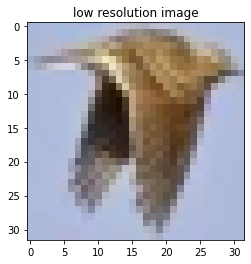

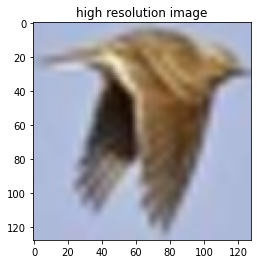

In [8]:
# Load image data
ishape = 128
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

# Reduce the dataset
train_image = train_images[0:10000]
test_image = test_images[0:1000]

x_train = np.array([img for img in train_image])
x_test = np.array([img for img in test_image])

y_train = np.array([cv.resize(img, (ishape, ishape), interpolation=cv.INTER_CUBIC) for img in train_image])
y_test = np.array([cv.resize(img, (ishape, ishape), interpolation=cv.INTER_CUBIC) for img in test_image])

# Show an example image
example_idx = 123
plt.figure('LR')
plt.imshow(x_train[example_idx])
plt.title('low resolution image')
plt.figure('HR')
plt.imshow(y_train[example_idx])
plt.title('high resolution image')
plt.show()

In [9]:
# Train the model
def PSNR(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=255.0)

def SSIM(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=255.0)

model.compile(optimizer=keras.optimizers.Adam(0.0001), loss='mse', metrics=[PSNR, SSIM, 'accuracy'])

history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_split=0.2)

test_scores = model.evaluate(x_test, y_test, verbose=2)

print('Test loss:', test_scores[0])
print('Test mse:', test_scores[1])

# Save entire model to a HDF5 file
model.save('WDSR.h5')

Epoch 1/10
125/125 [==============================] - 60s 257ms/step - loss: 1202.3472 - PSNR: 19.1515 - SSIM: 0.3000 - accuracy: 0.5190 - val_loss: 399.3969 - val_PSNR: 22.5522 - val_SSIM: 0.4692 - val_accuracy: 0.6186
Epoch 2/10
125/125 [==============================] - 29s 231ms/step - loss: 292.0368 - PSNR: 24.0251 - SSIM: 0.5498 - accuracy: 0.6559 - val_loss: 209.7066 - val_PSNR: 25.3655 - val_SSIM: 0.6183 - val_accuracy: 0.6868
Epoch 3/10
125/125 [==============================] - 29s 233ms/step - loss: 171.5530 - PSNR: 26.3084 - SSIM: 0.6637 - accuracy: 0.7066 - val_loss: 136.0287 - val_PSNR: 27.2586 - val_SSIM: 0.7072 - val_accuracy: 0.7234
Epoch 4/10
125/125 [==============================] - 29s 233ms/step - loss: 117.9097 - PSNR: 27.9409 - SSIM: 0.7367 - accuracy: 0.7376 - val_loss: 98.6143 - val_PSNR: 28.6681 - val_SSIM: 0.7656 - val_accuracy: 0.7494
Epoch 5/10
125/125 [==============================] - 29s 233ms/step - loss: 88.5722 - PSNR: 29.1871 - SSIM: 0.7858 - accura

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


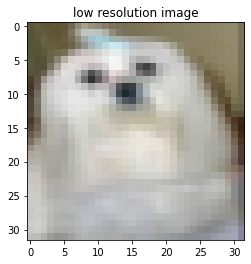

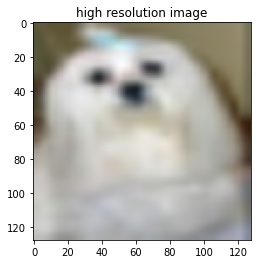

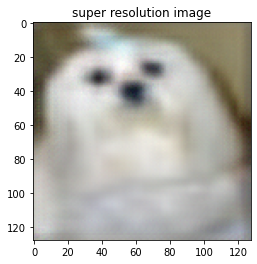

In [10]:
# Set real test image
img = train_images[20001]
lr = np.array(img)
hr = np.array(cv.resize(img, (ishape, ishape), interpolation=cv.INTER_CUBIC))
test_input = np.reshape(lr, (1, 32, 32, 3))

# Predict a result
sr = model.predict(test_input)
plt.figure('LR')
plt.title('low resolution image')
plt.imshow(lr)
plt.figure('HR')
plt.title('high resolution image')
plt.imshow(hr)
plt.figure('SR')
plt.title('super resolution image')
plt.imshow(sr[0] / 255.0)
plt.show()